##### NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `28`
* Students: `Guillain, Léonore Valentine; Pase, Francesco; Rusu, Cosmin-Ionut; Zhuang, Ying`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

###  Answer

In [2]:
import os

os.system('curl https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat 2&>/dev/null > airports.dat')

1792

In [3]:
#### run this line to download the data
!echo "Getting airports data"
!curl https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat 2&>/dev/null > airports.dat
!echo "Getting routes data"
!curl https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat 2&>/dev/null > routes.dat

Getting airports data
Getting routes data


In the flight routes dataset, the nodes correspond to individual airports, with routes being the edges. The features of each node are the information associated with the airport. Because the information of airports and routes is interconnected, we already preform some cleaning of the nodes and edges that relates the construction of the network in part B.

We only look at direct flights for now to get the physical routes as well as  for stops $> 0$ we don't know about the intermediate stops, which could hinder further analysis. 

In [4]:
airports = pd.read_csv('airports.dat', header=None, names=
                      ["AirportID","Name", "City", "Country", "IATA", "ICAO",
                       "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabaseTimeZone",
                       "Type", "Source"],
                       na_values = ["\\N"])

all_routes = pd.read_csv('routes.dat', header=None, names=
                     ['Airline', 'AirlineID', 'SourceAirport', 'SourceAirportID', 'DestinationAirport',
                      'DestinationAirportID', 'Codeshare', 'Stops', 'Equipment'],
                       na_values = ["\\N"])

routes = all_routes[all_routes.Stops == 0]
routes.reset_index(drop=True, inplace=True) #reset the index to (1, ..., nbr of entries)

We note that not all airports in the airport dataset have an IATA identifier. Those that do not have one maybe have an AirportID. However, we can not merge any airport that does not have an IATA identifier based on Airport ID, as seen below:

In [5]:
no_IATA_airports = airports[(airports.IATA.isna() & ~airports.AirportID.isna())]

#checking if we can associate the nodes to edges if we have no IATA information
print('Nodes with id matching destination airport id in routes: ', 
      pd.merge(no_IATA_airports, routes, left_on='AirportID', right_on='DestinationAirportID').shape[0]) 
print('Nodes with id matching source airport id in routes: ', 
      pd.merge(no_IATA_airports, routes, left_on='AirportID', right_on='SourceAirportID').shape[0])

Nodes with id matching destination airport id in routes:  0
Nodes with id matching source airport id in routes:  0


Hence we will use IATA to match edges (routes dataset) to the nodes (airport dataset) and we can already drop all the lines that have no IATA identifier.

In [6]:
airports = airports[~airports.IATA.isna()].reset_index(drop=True)

We noticed that there are issues with airports in routes not being present in the airports dataset. This means that we have no information about the source/destiantion of an edge. (Proof of statement seen bellow)

In [7]:
set(routes.DestinationAirport.unique()).union(set(routes.SourceAirport.unique())) in set(airports.IATA.unique())

False

We remove these edges as they will hinder our analysis. We won't have features associated to the start of endpoint of these edges.

In [8]:
inter = airports.IATA.unique() #get list of airport codes in airport dataset
routes = routes[routes.apply(lambda x: x['SourceAirport'] in inter and x['DestinationAirport'] in inter, axis=1)]

Conversely we can use this code to remove airports that are isolated:

In [9]:
print('Number of airports in dataset : ', airports.shape[0])

route_ids = list(set(routes.DestinationAirport.unique()).union(set(routes.SourceAirport.unique())))
print('Number of isolated airports', airports[airports.IATA.map(lambda x: not x in route_ids)].shape[0])

airports = airports[airports.IATA.map(lambda x: x in route_ids)].reset_index(drop=True)
print('Number of airports after removing isolated nodes: ', airports.shape[0])

Number of airports in dataset :  5652
Number of isolated airports 2473
Number of airports after removing isolated nodes:  3179


Thirdly, as there are routes who's source and destiantion are the same, we remove those are we are not interessted in them.

In [10]:
routes = routes[routes.SourceAirport != routes.DestinationAirport]

In [11]:
# the pandas dataframe with the features and labels
features = airports 
features.head()

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabaseTimeZone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

In [12]:
# Your code here

#using the code given in the tutorial
nodes = features.copy()
edges = routes[['SourceAirport', 'DestinationAirport']]

nodes.reset_index(level=0, inplace=True)
nodes = nodes.rename(columns={'index':'node'})

uid2idx = nodes[['node', 'IATA']]
uid2idx = uid2idx.set_index('IATA')

edges = edges.join(uid2idx, on='SourceAirport')
edges = edges.join(uid2idx, on='DestinationAirport', lsuffix='_source', rsuffix='_dest')
edges = edges.drop(columns=['SourceAirport','DestinationAirport'])

edges.head()

,node_source,node_dest
0,1421,1439
1,1422,1439
2,1422,1418
3,1424,1439
4,1424,2052


In [13]:
n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in edges.iterrows():
    if np.isnan(row.node_source) or np.isnan(row.node_dest):
        continue
    i, j = int(row.node_source), int(row.node_dest)
    
    # we add weights to the adjency matrix correspinding to the number of flights between i and j
    # our graph is directed, we add an edge when there is flight from source to dest
    adjacency[i, j] += 1

In [14]:
print('Our matrix is {} by {}'.format(adjacency.shape[0], adjacency.shape[1])) 
print('Number of edges : ', adjacency[adjacency > 0].shape[0])

Our matrix is 3179 by 3179
Number of edges :  36433


## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

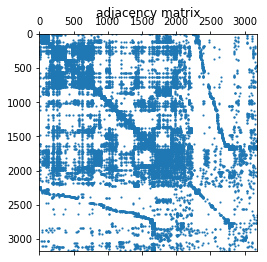

In [15]:
plt.spy(adjacency, markersize=1)
_ = plt.title('adjacency matrix')

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [16]:
# gives matrix with 1 where there is a connection, 0 otherwise
links = np.where(adjacency != 0, 1, 0)

print("Number of links (directed) L in our network: {}".format(links.sum()))
print("Number of links Lmax: {}".format(adjacency.shape[0]*(adjacency.shape[0]-1)))

Number of links (directed) L in our network: 36433
Number of links Lmax: 10102862


**Your answer here.**

A fully connected directed network, with no self-loops where no edges can be added, we have at most $L_{max} = N*(N-1)$ edges. 
In our case this would be 31939452 edges, a number much larger than the 36433 edges we have in our network.

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**Your answer here.**

As having a flight from source to destination does not imply that there is a flight from that destination to that source, our graph is directed, but it is close to being symetric, as for most flights from i to j, there will also be a flight from j to i.

In [17]:
adjacency_sym = np.maximum(adjacency, adjacency.T)

#sanity test
print('Number of directed links: ', np.where(adjacency_sym != 0, 1, 0).sum())
print('Number of (undirected) links: ', np.where(adjacency_sym != 0, 1, 0).sum()/2)

Number of directed links:  37232
Number of (undirected) links:  18616.0


### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [18]:
features.to_csv('features.csv')
np.save('adjacency_sym', adjacency_sym)

### Question 4

Are the edges of your graph weighted?

**Your answer here.**

Yes, we add weights based on the number of connections between two airport. For instance, entry $A_{a, b} = 5$  in the adjacency matrix $A$ indicates that there are 5 different direct ways to go from airport $a$ to airport $b$.

### Question 5

What is the degree distibution of your network? 

In [18]:
unweighted_links = np.where(adjacency != 0, 1, 0)

degree = unweighted_links.sum(axis=1)
assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

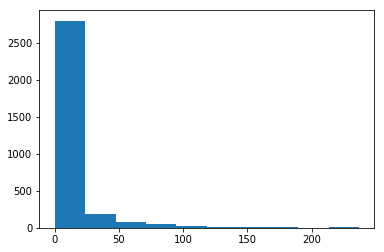

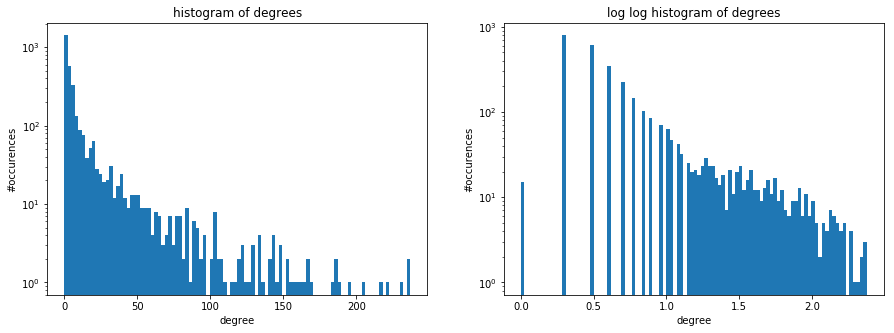

In [19]:
weights = np.ones_like(degree) 
plt.hist(degree, weights=weights)
plt.show()


#modified to plots for nicer plotting
weights = np.ones_like(degree) 

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.set_title('histogram of degrees')
ax1.set_xlabel('degree')
ax1.set_ylabel('#occurences')
ax1.hist(degree, weights=weights, bins=100, log=True)

ax2.set_title('log log histogram of degrees')
ax2.set_xlabel('degree')
ax2.set_ylabel('#occurences')

# use degree + 1 so we can do log log ...
ax2.hist(np.log10(degree+1), weights=weights, bins=100, log=True)

plt.show()

In [20]:
#check number of isolated nodes
print('we have {} zero outdegree nodes (traps)'.format(np.where(degree == 0, 1, 0).sum()))

we have 15 zero outdegree nodes (traps)


What is the average degree?

In [21]:
# Your code here.
print('the average degree is : ', degree.mean())

the average degree is :  11.460522176785153


### Question 6

Comment on the degree distribution of your network.

In [22]:
#Network empirical variance
print('The empirical variance is: ', degree.var())
#Max degree
print('Max. degree is:', degree.max())

The empirical variance is:  605.8193757575295
Max. degree is: 237


**Your answer here.**

By looking at the degree distribution it's quite clear how our network lacks particular structure having both many low-degree nodes and big hubs (degree higher than $200$). Being more analitycal, if we compute the empirical variance of the node degrees we obtain $605.82$ that's very far from the mean, so the distribution is far from being approximated by a Poissonian. Moreover, by taking the max. degree $k_{max} = 237$ we can see that its order of magnitude is more a polinomial function of N rather than logarthmic. Applying the formula seen in class we can also approximate the value of $\gamma$ : $k_{max} \sim N^{\frac{1}{\gamma - 1}}$ yielding $ \gamma \sim 2,47$ that falls exactly in the scale-free regime.

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [23]:
def dfs(node, adj, visited):
    visited[node] = 1
    for nxt, w in enumerate(adj[node]):
        if w > 0 and not visited[nxt]:
            dfs(nxt, adj, visited)

def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    # Your code here.
    nodes = adjacency.shape[0]
    cnt = 0
    visited = np.zeros(nodes)
    for i in range(nodes):
        if not visited[i]:
            cnt += 1
            if cnt > 1:
                return False
            dfs(i, adjacency, visited)
    return True

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [24]:
print('Is our graph connected (but not strongly)? : ', connected_graph(adjacency_sym))

print('Is our graph strongly connected? ', connected_graph(adjacency))

Is our graph connected (but not strongly)? :  False
Is our graph strongly connected?  False


### Question 8

Write a function that extracts the connected components of a graph.

In [25]:
def dfs(node, adj, visited, component):
    component.append(node)
    visited[node] = 1
    for nxt, w in enumerate(adj[node]):
        if w > 0 and not visited[nxt]:
            dfs(nxt, adj, visited, component)

def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    # Your code here.
    components = []
    nodes = adjacency.shape[0]
    visited = np.zeros(nodes)
    for i in range(nodes):
        if not visited[i]:
            component = []
            dfs(i, adjacency, visited, component)
            components.append(np.array(component))
    return np.array(components)

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [26]:
# Counting connected components (not strongly connected)
# This is why we use the symetrized matrix
components = find_components(adjacency_sym)

In [27]:
print('Number of components : ', components.shape[0])
print('Size of largest connected component: ', max(map(lambda x: x.shape[0], components)))

Number of components :  7
Size of largest connected component:  3154


### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [28]:
def compute_shortest_path_lengths(adjacency, source):
    
      
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """
    
    #Mask the adjacency matrix to forget about the weights
    masked_adj = adjacency.copy()
    masked_adj[masked_adj > 0] = 1
    
    #Vector for the shortest paths, initializate it with source row (all neighbors have distance 1)
    shortest_path_lengths = masked_adj[source].copy() * 1.
    shortest_path_lengths[shortest_path_lengths == 0] = np.inf
    shortest_path_lengths[source] = 0
    
    #Vectors with solved and not-solved nodes.
    S = set({source})
    N = set([ x for x in range(masked_adj.shape[0])])
    N.remove(source) 
    
    #Keep iterating until all nodes have been soleved (i.e. shortest path from source computed)
    while (len(N)):
        #Find the node with minimun distance among the not-solved ones
        min_d = np.inf
        for i in N:
            if (shortest_path_lengths[i] < min_d):
                min_d = shortest_path_lengths[i]
                min_id = i
        #Check whether 'source' belongs to not fully-connected component (end condition)
        if (min_d < np.inf):
            N.remove(min_id)
            S.add(min_id)
            
            for j in N:
                #Dummy statement we want hop distance, kept as real Dijkstra's algorithm
                if (masked_adj[min_id, j] == 1 and shortest_path_lengths[j] > shortest_path_lengths[min_id] + masked_adj[min_id, j]):
                    shortest_path_lengths[j] = shortest_path_lengths[min_id] + masked_adj[min_id, j]
        else:
            break
    #Nodes that are not connceted to source will have infinite distance
    return shortest_path_lengths


### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [29]:
def compute_diameter (adjacency):
    #Sample size for computing the diameter
    sample_size = 1000
    #Randomly select sample_size nodes and create adjacency matrix of the subgraph
    random_id = np.random.randint(adjacency.shape[0], size=sample_size)
    sub_adj = adjacency[random_id, :]
    sub_adj = sub_adj[:,random_id]
    
    diameter = 0.
    #Find longest shortest path (i.e. diameter)
    for i in range(sample_size):
        
        #Compute the maximum distance removing infinity values (isolated components)
        dis = compute_shortest_path_lengths(sub_adj, i)
        dis[dis == np.inf] = 0
        max_distance = dis.max()
        
        if (diameter < max_distance):
            diameter = max_distance
        
    return diameter

In [30]:
compute_diameter(adjacency)

8.0

### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [31]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    
    #define matrix that is 1 where there is a link, 0 otherwise
    adj = np.where(adjacency != 0, 1, 0)
    
    #takes matrix adj to power length
    paths_matrix = np.linalg.matrix_power(adj, length)
    n_paths = paths_matrix[source][target]
    return n_paths

Test your function on 5 pairs of nodes, with different lengths.

In [32]:
#lot of them are zero because nodes near in matrix are not necessarily close in real topology.
#also might be due to removing routes with intermediate stops
print(compute_paths(adjacency, 0, 10, 1))
print(compute_paths(adjacency, 0, 10, 2))
print(compute_paths(adjacency, 0, 10, 3))
print(compute_paths(adjacency, 23, 67, 2))
print(compute_paths(adjacency, 15, 93, 4))

0
0
0
1
0


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [33]:
adj = np.where(adjacency !=0, 1, 0)
paths_matrix = np.linalg.matrix_power(adj, 3)

In [34]:
print('Number of paths of length 3 between any two nodes: ', paths_matrix.sum())

Number of paths of length 3 between any two nodes:  147523969


### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [35]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    #Create set with neighbors of node
    neighbors = set(np.nonzero(adjacency[node])[0])
    n = len(neighbors)
    a=0
    for i in neighbors:
        #intersection between neighbors of neighbors of node and neighbors of node
        a += len(set(np.nonzero(adjacency[i])[0]).intersection(neighbors))
    #0 or 1 neighbors
    if (n>1):
        #Directed graph so there's no factor 2 
        clustering_coefficient = (a)/(n*(n-1))
    else:
        return 0.
    return clustering_coefficient

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [36]:
avg_clustering = 0
for i in range(n_nodes):
    avg_clustering += compute_clustering_coefficient(adjacency, i)
print('The average clustering coefficient is: ', avg_clustering/n_nodes)

The average clustering coefficient is:  0.4572845332977492
